## Session 13 - Machine Learning for Business and Analytics
### Materials - Dataset: Titanic

**Content Materials**

1. EDA, Data Preprocessing and Feature Engineering
2. Interpretable Machine Learning
    - Regression-based Interpretation
    - Decision Tree Plot
    - Decision Boundary of SVC and k-Means
    - Dendogram of Hierarchical Clustering
3. Explainable Machine Learning
    - Partial Dependence
    - Feature Importance
    - Shapley Value of Explanation (SHAP)
    - Local Interpretable Model-agnostic Explanation (LIME)

## 0. Import used Libraries

In [1]:
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from sklearn.preprocessing import LabelEncoder

import string
import warnings
warnings.filterwarnings('ignore')

## 1. Read Data

In [2]:
df = pd.read_csv("data_titanic.csv")
df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

## 2. EDA, Preprocessing and Feature Engineering

In data preprocessing and feature engineering, we would like to ensure there is no problem per feature, so we gonna check every feature that we have one by one.

**0. Missing Values Detection**

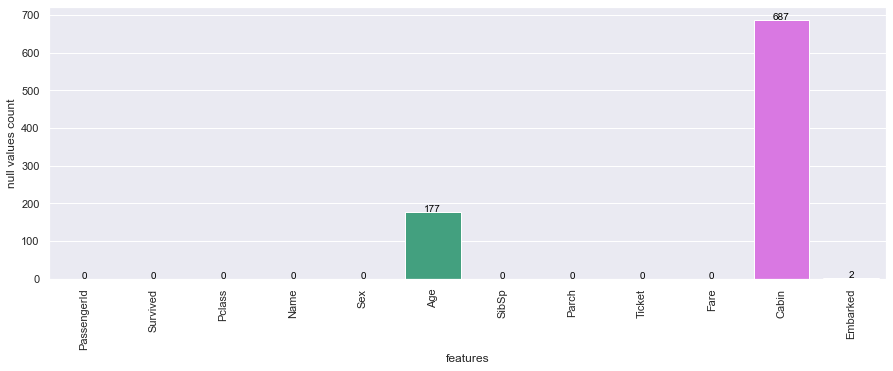

In [3]:
null_df = df.isnull().sum().reset_index()
plt.figure(figsize=(15,5))
ax = sns.barplot(null_df["index"], null_df[0], palette="husl")
ax.set(xlabel="features", ylabel="null values count")
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
ax.set_ylim(0)
[ax.text(index,value[1],value[1], color='black', ha="center") for index,value in enumerate(null_df.values)]
plt.show()

There are missing values on feature Age, Cabin, and Embarked. However, we won't directly remove those features since we are going to handle those missing values in each feature. 

**1. Age**

In [4]:
df['Age'].nunique()

88

In [5]:
print(f"Unique Value of feature Age is: {df['Age'].nunique()}")
df["Age"].describe()

Unique Value of feature Age is: 88


count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Since `Age` feature has relatively high gap between max and min value and high standard deviation (1/2 of its average), so its better to transform into categorical (age group). First of all, we should fill the null values with median based on `Sex` and `Pclass` to shape better pattern of data.

In [6]:
# Missing value handling
df["Age"] = df.groupby(["Sex", "Pclass"])["Age"].apply(lambda x: x.fillna(x.median()))
# Create age group by 10 groups
df["Age"] = pd.qcut(df["Age"], 10)
df["Age"].head()

0    (20.0, 22.0]
1    (34.0, 40.0]
2    (25.0, 26.0]
3    (34.0, 40.0]
4    (34.0, 40.0]
Name: Age, dtype: category
Categories (10, interval[float64]): [(0.419, 16.0] < (16.0, 20.0] < (20.0, 22.0] < (22.0, 25.0] ... (30.0, 34.0] < (34.0, 40.0] < (40.0, 47.0] < (47.0, 80.0]]

In [7]:
# Age group distribution by passenger id
df.groupby(["Age"])["PassengerId"].count()

Age
(0.419, 16.0]    100
(16.0, 20.0]      79
(20.0, 22.0]      94
(22.0, 25.0]     164
(25.0, 26.0]      18
(26.0, 30.0]     101
(30.0, 34.0]      69
(34.0, 40.0]     116
(40.0, 47.0]      61
(47.0, 80.0]      89
Name: PassengerId, dtype: int64

**2. Embarked**

In [8]:
# Lets see the value distribution
df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [9]:
# Filling the missing values in Embarked with S, as its mode (appears most frequent)
df["Embarked"] = df["Embarked"].fillna("S")
df["Embarked"].head()

0    S
1    C
2    S
3    S
4    S
Name: Embarked, dtype: object

**3. Fare**

In [10]:
print(f"Unique Value of feature Age is: {df['Age'].nunique()}")
df["Fare"].describe()

Unique Value of feature Age is: 10


count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

The situation is similar with `Age` feature, where standard deviation > mean, while unique value is only 10. In such way, its better to transform this feature into categorical data (fare-group). We are going to make a `Fare` group into 10 groups.

In [11]:
df["Fare"] = pd.qcut(df["Fare"], 10)
df["Fare"].head()

0      (-0.001, 7.55]
1    (39.688, 77.958]
2       (7.854, 8.05]
3    (39.688, 77.958]
4       (7.854, 8.05]
Name: Fare, dtype: category
Categories (10, interval[float64]): [(-0.001, 7.55] < (7.55, 7.854] < (7.854, 8.05] < (8.05, 10.5] ... (21.679, 27.0] < (27.0, 39.688] < (39.688, 77.958] < (77.958, 512.329]]

**4. Family Size**

- `SibSp`: Number of Siblings/Spouses Aboard
- `Parch`: Number of Parents/Children Aboard

We are going to make new feature: `Family Size` which consist of `SibSp`, `Parch`, and its passenger. Then, we create new feature `Family Size Group` based on family size number, while remove the numerical feature afterwards.

In [12]:
df["Family_Size"] = df["SibSp"] + df["Parch"] + 1
family_map = {1: "Alone", 2: "Small", 3: "Small", 4: "Small", 5: "Medium", 6: "Medium", 7: "Large", 8: "Large", 11: "Large"}
df["Family_Size_Grouped"] = df["Family_Size"].map(family_map)
df["Family_Size_Grouped"].head()

df.drop(["Family_Size"], inplace=True, axis=1)
df["Family_Size_Grouped"].head()

0    Small
1    Small
2    Alone
3    Small
4    Alone
Name: Family_Size_Grouped, dtype: object

**5. Cabin**

`Cabin` has most missing value in the dataset, however we are going to create new feature: named `Deck`. This feature describes the group name if deck position based on the first alphabetic letter in `Cabin` value, let say `C85` means `C` for `Deck`. The missing `Cabin` will be replaced by `M` which stands for `missing`

In [13]:
# Missing value into "M" deck~ missing deck
df["Deck"] = df["Cabin"].apply(lambda s: s[0] if pd.notnull(s) else "M")
# Replace value "T" into "A"
idx = df[df["Deck"] == "T"].index
df.loc[idx, "Deck"] = "A"
# Create three group replacement of A-G
df["Deck"] = df["Deck"].replace(["A", "B", "C"], "ABC")
df["Deck"] = df["Deck"].replace(["D", "E"], "DE")
df["Deck"] = df["Deck"].replace(["F", "G"], "FG")
# Remove Cabin since its unused
df.drop(["Cabin"], inplace=True, axis=1)

df["Deck"].head()

0      M
1    ABC
2      M
3    ABC
4      M
Name: Deck, dtype: object

**6. Ticket and PClass**

In [14]:
df["Ticket"].value_counts()

1601                 7
CA. 2343             7
347082               7
CA 2144              6
347088               6
                    ..
239854               1
312993               1
SOTON/O.Q. 392087    1
11769                1
364848               1
Name: Ticket, Length: 681, dtype: int64

Feature `Ticket` has many unique values (681), so we will transform this into `Ticket Frequency` based on its appearance of each ticket. 

In [15]:
df["Ticket_Frequency"] = df.groupby("Ticket")["Ticket"].transform("count")
df.drop(["Ticket"], inplace=True, axis=1)

df["Pclass"] = df["Pclass"].astype("str")

df["Ticket_Frequency"].head()

0    1
1    1
2    1
3    2
4    1
Name: Ticket_Frequency, dtype: int64

**7. Name**

We try to extract the name, by its title and marriage status, we create `Title` and `Is Married` as new features

In [16]:
df["Title"] = df["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
df["Is_Married"] = "no"
df["Is_Married"].loc[df["Title"] == "Mrs"] = "yes"

df.drop(["Name"], inplace=True, axis=1)

df[["Title","Is_Married"]].head()

Title Is_Married
0    Mr         no
1   Mrs        yes
2  Miss         no
3   Mrs        yes
4    Mr         no

**Final Cleanup**

In [17]:
# Since this feature is no longer be used, now we remove this
df.drop(["PassengerId"], inplace=True, axis=1)

**Check Recent Data**

In [18]:
df.head()

Survived Pclass     Sex           Age  SibSp  Parch              Fare  \
0         0      3    male  (20.0, 22.0]      1      0    (-0.001, 7.55]   
1         1      1  female  (34.0, 40.0]      1      0  (39.688, 77.958]   
2         1      3  female  (25.0, 26.0]      0      0     (7.854, 8.05]   
3         1      1  female  (34.0, 40.0]      1      0  (39.688, 77.958]   
4         0      3    male  (34.0, 40.0]      0      0     (7.854, 8.05]   

  Embarked Family_Size_Grouped Deck  Ticket_Frequency Title Is_Married  
0        S               Small    M                 1    Mr         no  
1        C               Small  ABC                 1   Mrs        yes  
2        S               Alone    M                 1  Miss         no  
3        S               Small  ABC                 2   Mrs        yes  
4        S               Alone    M                 1    Mr         no

**Check Data Cardinality**

Data with high cardinality will slow down the process of machine learning if we transform into dummy variables, in such way, we would like to transform data with high cardinality into ordinal-based data.

In [19]:
for x in df.columns:
    total_unique_values = len(df[x].unique())
    print(f"Unique value of {x} is {total_unique_values}")

Unique value of Survived is 2
Unique value of Pclass is 3
Unique value of Sex is 2
Unique value of Age is 10
Unique value of SibSp is 7
Unique value of Parch is 7
Unique value of Fare is 10
Unique value of Embarked is 3
Unique value of Family_Size_Grouped is 4
Unique value of Deck is 4
Unique value of Ticket_Frequency is 7
Unique value of Title is 17
Unique value of Is_Married is 2


Feature `Age`, `Fare` and `Title` has so many unique values (>10). Since `Age` and `Fare` are numerical feature, where 0 > 1, so we transform into ordinal-based data type, while we let `Title` feature working as usual

In [20]:
high_cardinality_data = ["Fare","Age"]

for feature in high_cardinality_data:        
    df[feature] = LabelEncoder().fit_transform(df[feature])

df_encoded = pd.get_dummies(df)
df_encoded.head()

Survived  Age  SibSp  Parch  Fare  Ticket_Frequency  Pclass_1  Pclass_2  \
0         0    2      1      0     0                 1         0         0   
1         1    7      1      0     8                 1         1         0   
2         1    4      0      0     2                 1         0         0   
3         1    7      1      0     8                 2         1         0   
4         0    7      0      0     2                 1         0         0   

   Pclass_3  Sex_female  ...  Title_Mlle  Title_Mme  Title_Mr  Title_Mrs  \
0         1           0  ...           0          0         1          0   
1         0           1  ...           0          0         0          1   
2         1           1  ...           0          0         0          0   
3         0           1  ...           0          0         0          1   
4         1           0  ...           0          0         1          0   

   Title_Ms  Title_Rev  Title_Sir  Title_the Countess  Is_Married_no  \
0         0          0          0                   0              1   
1         0          0          0                   0              0   
2         0          0          0                   0              1   
3         0          0          0                   0              0   
4         0          0          0                   0              1   

   Is_Married_yes  
0               0  
1               1  
2               0  
3               1  
4               0  

[5 rows x 41 columns]

## 3. Modeling Stage

Now lets move to the main dish, we are not giving too much focus on hyperparameter/model selection since our objective is creating interpretable AI and explainable AI, so let use the normal stages of machine learning building. 

**a. Set X and Y features**

In [21]:
# Separate between X and y features
X = df_encoded.drop(["Survived"],axis=1)
y = df_encoded["Survived"].values
# Store the column names
feature_names = X.columns
target_names = "Survived"

**b. PCA to transform 2D Vectors**

In [22]:
from sklearn.decomposition import PCA

# We create PCA to transform all of X features into 2D vectors
# PCA will be used on plotting 2D contour
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ["PC1","PC2"])

**c. Train Test Split**

In [23]:
from sklearn.model_selection import train_test_split

# Ratio 70 : 30
# Normal Dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=123)

# Principal Component Dataset
X_train_pc, X_test_pc, y_train_pc, y_test_pc = train_test_split(principalDf,y,test_size=0.3,random_state=123)

**Don't forget to import these:**

In [24]:
import plotly.express as px
import plotly.graph_objects as go

### a. Interpretable ML

Interpretability is the degree to which a human can understand the cause of a decision

- Regression Plot 
- Decision Tree Plot
- Decision Boundary of SVC
- Dendogram of Hierarchical Clustering

**Regression Based Interpretation**

We are making interpretable AI: **Regression Analysis**

In this model, we are not focusing on how to reach highest accuracy, but how to make people understand about how Regression is actually works. So, we chose `Logistic Regression` model since it is interpretable by calculating its regression coefficients.

In [25]:
import statsmodels.api as sm

X_sm = sm.add_constant(X)

clf_logit = sm.Logit(y, X_sm)

odds_ratio = [round(x,2) for x in np.exp(clf_logit.fit().params.values)]

print(odds_ratio[:5])
print(clf_logit.fit().summary())

         Current function value: 0.392403
         Iterations: 35
[0.0, 0.91, 0.8, 0.98, 1.05]
         Current function value: 0.392403
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  891
Model:                          Logit   Df Residuals:                      858
Method:                           MLE   Df Model:                           32
Date:                Mon, 26 Apr 2021   Pseudo R-squ.:                  0.4107
Time:                        12:30:13   Log-Likelihood:                -349.63
converged:                      False   LL-Null:                       -593.33
Covariance Type:            nonrobust   LLR p-value:                 7.548e-83
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const            

***
$\mathbf{\text{Logistic Regression Explanation}}$<br>
***
1.&emsp;Logistic Regression Formula: 
$$P = \frac{e^{\alpha+\beta X}}{1+e^{\alpha+\beta X}}$$

2.&emsp;We have 40 features of X, lets take 3 of them: `Intercept` = -41.7286, `Age` = -0.0891, `SibSp` = -0.2282, `Parch` = -0.0169, then:

$$P = \frac{e^{-41.7286 -0.0891 X_{Age} -0.2282 X_{SibSp} -0.0169 X_{Parch} + ... + \beta X}}{1+e^{-41.7286 -0.0891 X_{Age} -0.2282 X_{SibSp} -0.0169 X_{Parch} + ... + \beta X}}$$

3.&emsp;One of the way to interpret the cofficients is using odds ratio score for each feature, lets take `Fare` whose odds ratio score is 1.05. It means, when `Fare` is increasing (1 group) then the probability to survive is increasing by 5%.

**Decision Tree Plot**

We are making interpretable AI: **Decision Tree Analysis**

In this model, we are not focusing on how to reach highest accuracy, but how to make people understand about how Decision tree and its derivatives are actually works. So, we chose `Decision Tree Classifier` and `Random Forest Classifier` models since they can produce decision tree plot.

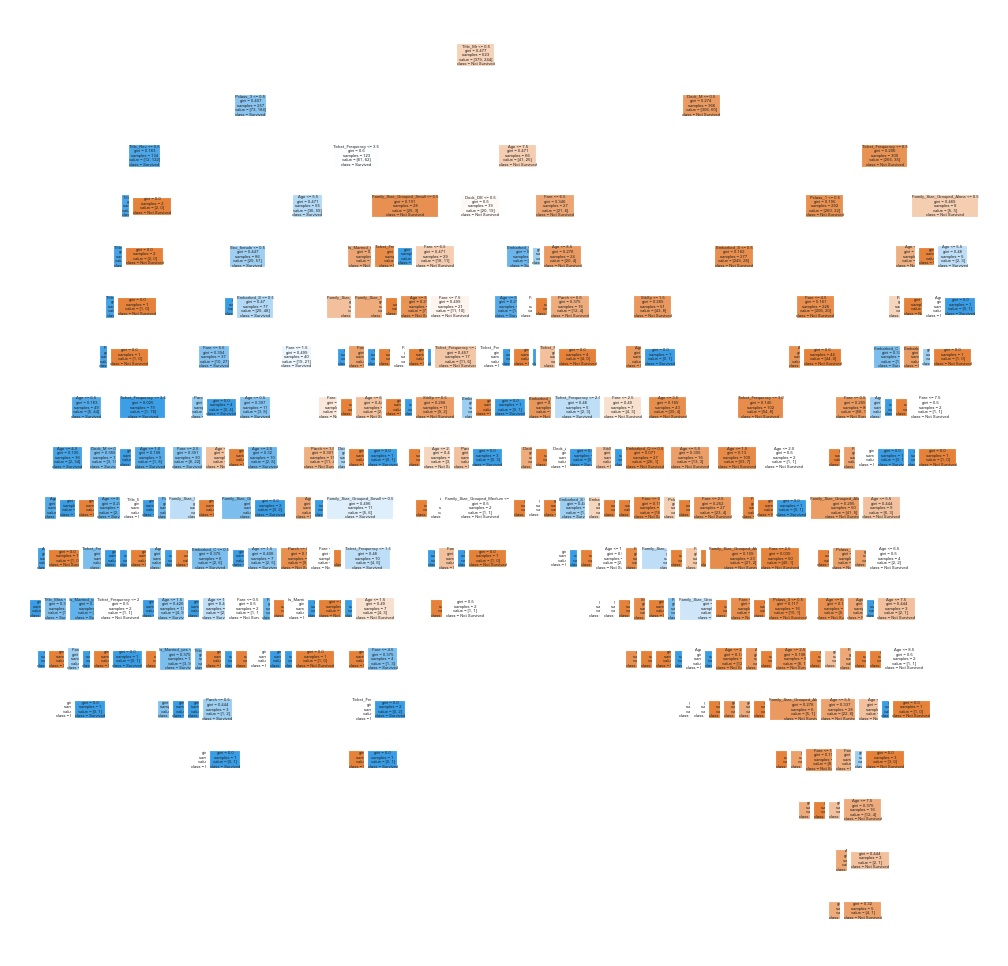

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Create classifier
clf_decisiontree = DecisionTreeClassifier()
clf_decisiontree.fit(X_train,y_train)
y_pred_decisiontree = clf_decisiontree.predict(X_test)

# Create the tree map
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
plot_tree(clf_decisiontree,
               feature_names = feature_names, 
               class_names=["Not Survived","Survived"],
               filled = True)

# Save the picture in the same location of this document
fig.savefig("decision_tree_figure.png")

The tree map logic (IF ELSE algorithm through all trees) can be read easily. However, due to massive features trained in the model, so it is difficult to read the logic unless we can zoom into the specific location. Nevertheless, by showing this into your stakeholder, they will understand of how the ML classify the business objective with IF ELSE logic that has been planted inside our model. 

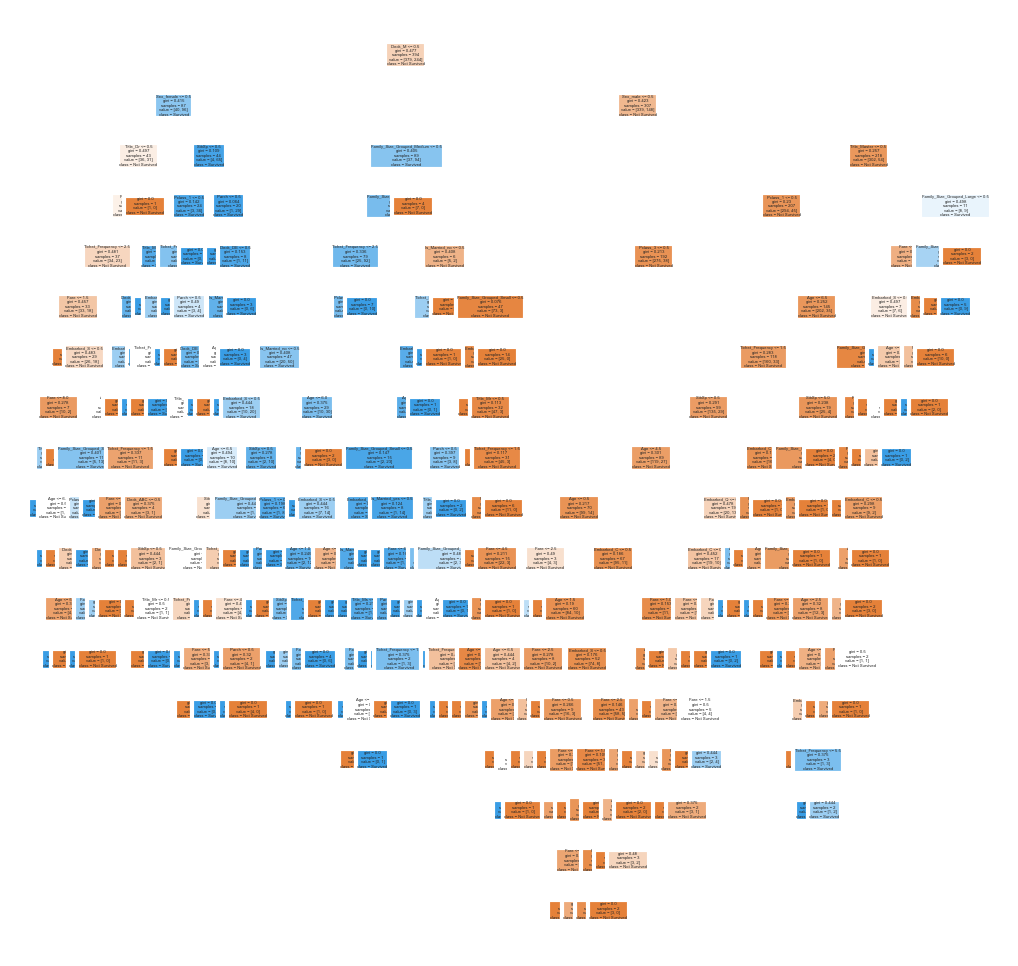

In [27]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest Model and train it
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train,y_train)
y_pred_rf = clf_rf.predict(X_test)

# Create the plot 
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
plot_tree( clf_rf.estimators_[0],
           feature_names = feature_names, 
           class_names=["Not Survived","Survived"],
           filled = True)

# Store whenever it is needed
fig.savefig("random_forest_figure.png")

This is actually same, however different algorithm will returns different result too. So it is better to maximize the accuracy before going to present to the stakeholder since there might be any changes in the tree logic inside your ML model.

**Plot Decision Boundary**

We are making interpretable AI: **Decision Boundary**

Decision boundary is basically a hypersurface that partitions the underlying vector space into two sets, one for each class. The classifier will classify all the points on one side of the decision boundary as belonging to one class and all those on the other side as belonging to the other class. We can create decision boundary to all classifying model, however since the hypersurface is normally 2D/3D formats, so our features maximumly should not be higher than 3 features. Hence, we are using Principal Component features to simplify the number of features we have into 2 / 3 Principal components.


In this practice, we will use `Support Vector Machine - Sigmoid kernel` to visualize the decision boundary.

In [28]:
# Please do not touch, code to generate decision boundary
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

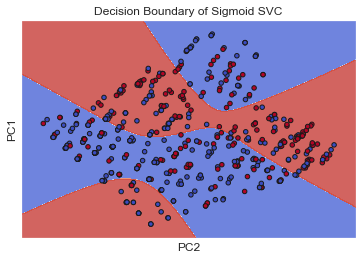

In [29]:
from sklearn.svm import SVC

np.random.seed(123)
# Create the model and train it using principal component features
model = SVC(kernel="sigmoid")
clf = model.fit(X_train_pc, y_train_pc)

# Set-up grid for plotting.
fig, ax = plt.subplots()
X0, X1 = X_train_pc.iloc[:, 0], X_train_pc.iloc[:, 1]
xx, yy = make_meshgrid(X0, X1)
# Create the plot
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=y_train_pc, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel("PC1")
ax.set_xlabel("PC2")
ax.set_xticks(())
ax.set_yticks(())
ax.set_title("Decision Boundary of Sigmoid SVC")
plt.show()

The decision boundary shows that the blue color is equal to 0 (Not Survived), while red color is equal to 1 (Survived). We can see the difference, which data points are correctly predicted and not.

**Dendogram of Clustering**

We are making interpretable AI: **Clustering Dendogram**

A dendrogram is a diagram that shows the hierarchical relationship between objects. It is most commonly created as an output from hierarchical clustering. The main use of a dendrogram is to work out the best way to allocate objects to clusters.

In this practice, we will use `Hierarchical clustering - centroid kernel` to visualize the dendogram

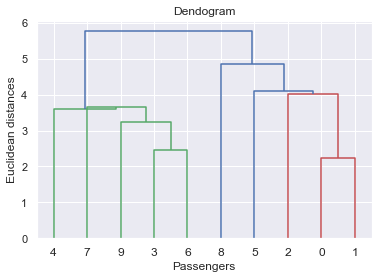

In [30]:
import scipy.cluster.hierarchy as sch

np.random.seed(123)

dendrogram = sch.dendrogram(sch.linkage(X_train.iloc[:10], method  = "centroid"))
plt.title("Dendogram")
plt.xlabel("Passengers")
plt.ylabel("Euclidean distances")
plt.show()

Dendogram classify row by row, you can differentiate between groups using the color that shown on each observation.

### b. Explainable ML
The use of machine learning models for the extraction of relevant knowledge about domain relationships contained in data

- Partial Dependence
- Feature Importance
- Shapley Value of Explanation (SHAP)
- Local Interpretable Model-agnostic Explanation (LIME)

We use `XGBoostClassifier` and `RandomForestClassifier` models as the base model to be explained.

In [31]:
# Base model
from xgboost import XGBClassifier

np.random.seed(123)
clf_xgb = XGBClassifier()
clf_xgb.fit(X_train,y_train)
y_pred_xgb = clf_xgb.predict(X_test)
y_pred_proba_xgb =  clf_xgb.predict_proba(X_test)

**Partial Dependence Plot**

We are making explainable AI: **Partial Dependence Plot**

A partial dependence (PD) plot depicts the functional relationship between a small number of input variables and predictions. They show how the predictions partially depend on values of the input variables of interest. For example, a PD plot can show whether the probability of survivability increases linearly with age.

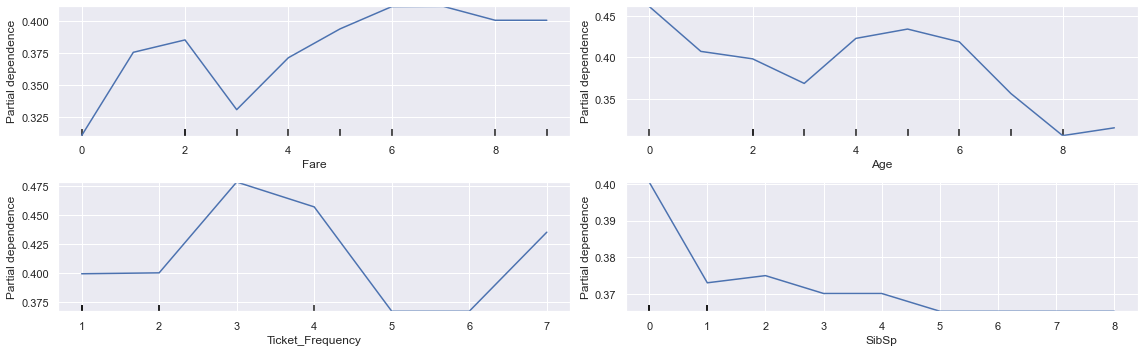

In [32]:
from sklearn.inspection import plot_partial_dependence

# We try to compare 4 features using partial dependence
fig, ax = plt.subplots(2,2, figsize=(16, 5))
plot_partial_dependence(clf_xgb, X_train,["Fare"], ax=ax[0,0])
plot_partial_dependence(clf_xgb, X_train,["Age"], ax=ax[0,1])
plot_partial_dependence(clf_xgb, X_train,["Ticket_Frequency"], ax=ax[1,0])
plot_partial_dependence(clf_xgb, X_train,["SibSp"], ax=ax[1,1])
plt.tight_layout()
plt.show()

***
$\mathbf{\text{How to Read}}$<br>
***
- `y` axis describes the probability of being `1` in prediction, it means that the probability of being `Survived`
- `x` axis describes the value of a selected feature, ranging from low value into higher value. Can be numerical or categorical feature

***
$\mathbf{\text{Business Insights}}$<br>
***

1.&emsp;`Fare`
<br>The higher fare paid, the higher probability to survive of the passengers. This is reasonable, because when you paid more, the facilities that you will get are somehow better than cheaper ticket, including the privilage to be evacuated first rather than the other passengers. </br>

2.&emsp;`Age`
<br>The younger you are, the higher probability to survive. This is reasonable too, since younger people most likely to be evacuated first rather than the old one.</br>

3.&emsp;`Ticket Frequency`
<br>When the passenger has a most frequent ticket, the higher probability to survive. It shows that when there are so many people with the same ticket level, they are easier to be classified as one group to evacuate. </br>

4.&emsp;`SibSp`
<br>When the passenger doesn't have too many siblings/relatives, it is easier to evacuate them since they have none of their family to be evacuated first rather than themselves. </br>

> You can add more business insight using the probability values, such as "The probability to survive will be increased by 6% of the passengers who have most expensive ticket compared to the cheapest ticket". It is easier to elaborate both the number and the pattern of partial dependence plot to convey your message to non-technical users. 

**Feature Importance Plot**

We are making explainable AI: **Feature Importance Plot**

Feature importance refers to a class of techniques for assigning scores to input features to a predictive model that indicates the relative importance of each feature when making a prediction.Feature importance scores can be calculated for problems that involve predicting a numerical value, called regression, and those problems that involve predicting a class label, called classification.

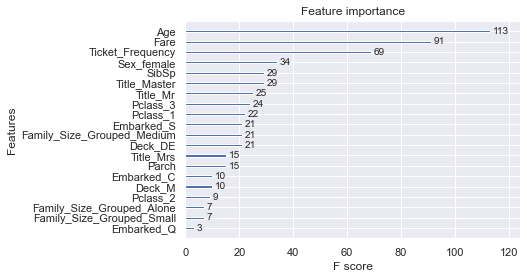

In [33]:
from xgboost import plot_importance

plot_importance(clf_xgb)
plt.show()

***
$\mathbf{\text{How to Read}}$<br>
***
- `y` axis describes your own features.
- `x` axis (F-score) describes how many times each feature is split on. The more split = the higher contribution to predict class 1/`Survived`

***
$\mathbf{\text{Business Insights}}$<br>
***

1.&emsp;**Most Important Features**
<br>Feature `Age`, `Fare`, `Ticket Frequency`, `SibSp` have higher contribution to the model, it means to decide whether a passenger will survive/not, please refer to these features first. </br>

2.&emsp;**Gender Factor**
<br>Gender Female `Sex_Female` and `Title_Mrs` has higher contribution rather than `Title_Mr` or `Sex_Male`. This situation shows that gender female is more prioritized to be evacuated rather than male.</br>


> Feature importance, can be used too in feature selection method. You can tune the model hyperparameter to reach better conclusion of the model in the future.

Further Readings:
- https://stats.stackexchange.com/questions/162162/relative-variable-importance-for-boosting

**Shapley Value of Explanations (SHAP)**

We are making explainable AI: **Shapley Value of Explanations (SHAP)**

Shapley Value is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions. SHAP plot describes better visualization in value-level, so we can entrust more on how our feature is being important to the model

In [34]:
import shap

shap_values = shap.TreeExplainer(clf_xgb,
                                 data = X_train,
                                 feature_dependence="independent",
                                 model_output="probability").shap_values(X_train)
shap.summary_plot(shap_values, X_train,feature_names = feature_names)

***
$\mathbf{\text{How to Read}}$<br>
***
- `y` axis describes your own features.
- `x` axis (SHAP) describes how much the contributions of each feature based on its value. The contribution is higher when the color is red, otherwise lower for blue dots. The determination of blue and red colors are based on its value to the 0.0 point. The right side of 0.0 axis means to support prediction into "1" value, while the left side supports "0" prediction. The SHAP value is like correlation coefficient, the magnitude meaning is equal between positive and negative.
- `Color between Red and Blue` means the how model determine whether the SHAP value supports "0" or "1" prediction. When the color is red and SHAP value has positive value, means that the feature is support "1" prediction, otherwise "0" prediction. 
- `Dot/Data point` shows the real data point in the dataset. 

**Sidenotes:**

>  We know that `Sex_female` has only 2 values, which is 0 (for not female), and 1 (for female boolean). Read from `X-axis = 0.0`. SHAP Values of `Sex Female`, which are on the right side of `X-axis = 0.0`, are red-colored. This means that when `Sex_female` score is = 1/True female boolean, so the probability of being `Survived/1` is much higher compared to the `not female/0`

> The differences between the top features compared to the bottom features relied on how strong the SHAP score value. Let's compare the `Title_Mr` (the very top feature) whose SHAP value can reach 0.3 points while `Embarked_Q` (the very bottom feature) has only lower than < 0.1 SHAP value. The higher feature position means the higher magnitude of the SHAP value range. 

***
$\mathbf{\text{Business Insights}}$<br>
***

1.&emsp;**Gender Factor**
<br>Feature `Sex_female` and `Sex_male` shown assertively that gender has very strong determination to decide whether a passenger will be survived or not. `Sex_male == False` and `Sex_female == True` predict the passenger to be survived more. </br>

2.&emsp;**PClass Comparison**
<br>A passenger who sat on `Pclass_1` has higher chance to be survived compared to `Pclass_3` and `Pclass_2`.</br>

3.&emsp;**Family Size Comparison**
<br>A passenger whose family size is `small`/`alone` has higher probability to be survived, compared to the larger one.</br>

4.&emsp;**Title Comparison**
<br>A passenger whose title is `Master`/`Mrs` has higher chance to be survived, compared to the other titles.</br>

> You can elaborate more with other features that you have. More information = stronger convince level to stakeholder

**Shapley Value of Explanations (SHAP) Per Observation Feature**

In [35]:
# Start js (must have)
shap.initjs()

In [36]:
def shap_plot(j,model,S):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

Lets take 3 random observations on the dataset, to learn about how each feature contribute to predict the target by its scores. Lets take the observation on 0, 1, and 6 index

In [37]:
# The X feature
X_test.iloc[[0,1,6]]

Age  SibSp  Parch  Fare  Ticket_Frequency  Pclass_1  Pclass_2  Pclass_3  \
172    0      1      1     4                 3         0         0         1   
524    3      0      0     0                 1         0         0         1   
161    7      0      0     5                 1         0         1         0   

     Sex_female  Sex_male  ...  Title_Mlle  Title_Mme  Title_Mr  Title_Mrs  \
172           1         0  ...           0          0         0          0   
524           0         1  ...           0          0         1          0   
161           1         0  ...           0          0         0          1   

     Title_Ms  Title_Rev  Title_Sir  Title_the Countess  Is_Married_no  \
172         0          0          0                   0              1   
524         0          0          0                   0              1   
161         0          0          0                   0              0   

     Is_Married_yes  
172               0  
524               0  
161               1  

[3 rows x 40 columns]

In [38]:
# The target feature
y_test[[0,1,6]]

array([1, 0, 1], dtype=int64)

How to write the code:

`shap_plot(INDEX,CLASSIFIER,FEATURES)`

**Test data at index 0**

In [39]:
# Lets compare with the real result
print(f"The prediction must predict this passenger is: {('Survived' if y_test[0] == 1 else 'Not Survived')} from y_test")

shap_plot(0,clf_xgb,X_test)

The prediction must predict this passenger is: Survived from y_test


The observation on index-0 of X_test, has `Family_Size_Grouped_Small = 1`, `Sex_Female = 1`, `Age = 0`, `Ticket_Frequency = 3`, `Title_Mr = 0`, `Pclass_3 = 1`, `Fare = 4`, `Embarked_S = 1`, and `Pclass_1 = 0`. 

In short, this passenger is a `young-aged` and `Female` who sat on `Pclass 3`, and having `small family size`. The model predicted this passenger is `Survived` since the **output value > 0** which is **0.68**.

> Short explanation: These features (`Title_Mr = 0`, `Ticket_Frequency = 3`, `Age = 0`, etc) support more impact on predicting target into 1, can be seen on the red-bar graph of their contributions, compared to the blue-bar graph.

The prediction result and the real dataset shown the same result, which is `Survived`. 

**Test Data at index 1**

In [40]:
# Lets compare with the real result
print(f"The prediction must predict this passenger is: {('Survived' if y_test[1] == 1 else 'Not Survived')} from y_test")

shap_plot(1,clf_xgb,X_test)

The prediction must predict this passenger is: Not Survived from y_test


The observation on index-0 of X_test, has `Embarked_C = 1`, `Embarked_S = 0`, `Title_Mr = 1`, `Sex_female = 0`, `Pclass_1 = 0`, `Pclass_3 = 1`, `Fare = 0`, `Deck_DE = 0`, `Ticket_Frequency = 1`

In short, this passenger is a `Male` who sat on `Pclass 3`, paid on `cheapest ticket class`, and `Embarked at C`. The model predicted this passenger is `Not Survived` since the **output value < 0** which is **-1.91**.

> Short explanation: These features (`Title_Mr = 1`, `Sex_female = 0`, `Pclass_1 = 0`, etc) support more impact on predicting target into 0, can be seen on the blue-bar graph of their contributions, compared to the red-bar graph.

The prediction result and the real dataset shown the same result, which is `Not Survived`. 

**Test Data at index 6**

In [41]:
# Lets compare with the real result
print(f"The prediction must predict this passenger is: {('Survived' if y_test[6] == 1 else 'Not Survived')} from y_test")

shap_plot(6,clf_xgb,X_test)

The prediction must predict this passenger is: Survived from y_test


Lets interpret this observation (index-6) together!



**Local Interpretable Model-agnostic Explanation (LIME)** 

We are making explainable AI: **Local Interpretable Model-agnostic Explanation (LIME)** 

LIME ( Local Interpretable Model-agnostic Explanations) is a novel explanation technique that explains the prediction of any classifier in an interpretable and faithful manner by learning an interpretable model locally around the prediction.

In [42]:
import lime
from lime import lime_tabular

# Base Classifier
rf_lime = RandomForestClassifier(random_state=123)
rf_lime.fit(X_train, y_train)
score = rf_lime.score(X_test, y_test)

In [43]:
# Explainer based
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['Not Survived', 'Survived'],
    mode='classification'
)

LIME used two main functions to show the explainer:
- `as_pyplot_figure()`: Only shows the feature importance with direction
- `show_in_notebook()`: Shows more complex visualization

**Explain Feature based on Pyplot**

The prediction must predict this passenger is: Survived from y_test


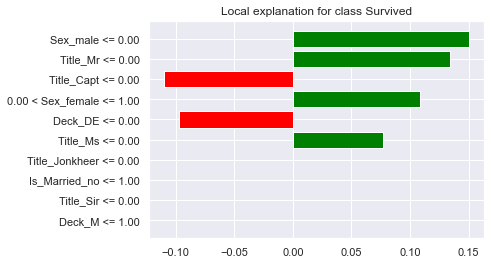

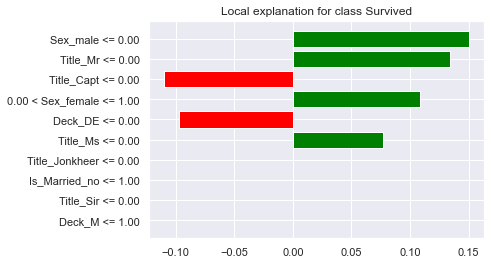

In [44]:
# Try to the observation 6
# Lets compare with the real result
print(f"The prediction must predict this passenger is: {('Survived' if y_test[6] == 1 else 'Not Survived')} from y_test")

exp = explainer.explain_instance(X_test.iloc[6], 
                                 rf_lime.predict_proba, 
                                 num_features=10)
exp.as_pyplot_figure()

***
$\mathbf{\text{How to Read}}$<br>
***
- `y` axis describes your own features.
- `x` axis describes how much the prediction probability to predict "1" (Survive). When the value is negative, so it will decrease the probability to be "1".
- `Color between Green and Red` means the how model determine whether the LIME supports "0" or "1" prediction. When the color is red and LIME value has negative value, means that the feature is support "0" prediction, otherwise "1" prediction. 

***
$\mathbf{\text{Business Insights}}$<br>
***

1.&emsp;**Gender Factor**
<br>Feature `Sex_male <= 0`, `Title_Mr <= 0`, and `0.00 < Sex_female <= 1.0` shown assertively that gender has very strong determination to decide whether a passenger will be survived. </br>

2.&emsp;**PClass Comparison**
<br>This passenger wasn't sit on `Pclass_1`, which will lower the chance to be survived (`PClass_1 <= 0`)</br>

> You can elaborate more with other features that you have. More information = stronger convince level to stakeholder

**Explain Feature based on Show in Notebook**

In [45]:
# Lets compare with the real result
print(f"The prediction must predict this passenger is: {('Survived' if y_test[1] == 1 else 'Not Survived')} from y_test")

exp = explainer.explain_instance(
    data_row=X_test.iloc[1], 
    predict_fn=rf_lime.predict_proba
)

exp.show_in_notebook(show_table=True)

The prediction must predict this passenger is: Not Survived from y_test


***
$\mathbf{\text{How to Read}}$<br>
***
- `y` axis describes your own features.
- `x` axis describes how much the prediction probability to predict "1" (Survive). When the value is negative, so it will decrease the probability to be "1".
- `Color between Blue and Orange` means the how model determine whether the LIME supports "0" or "1" prediction. When the color is blue and LIME value has negative value, means that the feature is support "0" prediction, otherwise orange stands for "1" prediction. 

At a glance, it is more readable compared to the previous one, using `pyplot method`. You can read and understand without any text support since everything written clearly. 

> You can elaborate more with other features that you have. More information = stronger convince level to stakeholder

In [46]:
# Lets compare with the real result
print(f"The prediction must predict this passenger is: {('Survived' if y_test[0] == 1 else 'Not Survived')} from y_test")

exp = explainer.explain_instance(
    data_row=X_test.iloc[0], 
    predict_fn=rf_lime.predict_proba
)

exp.show_in_notebook(show_table=True)

The prediction must predict this passenger is: Survived from y_test


Lets interpret this one together!

# Thank You